# **Data Cleaning**

## Objectives

* Clean data
* Perform Correlation and PPS analysis on cleaned dataset
* Split into train and test set
  
## Inputs

* The maternal health dataset from outputs/datasets/collection/maternal-healt-dataset.csv

## Outputs

* Generate cleaned train and test sets and save to outputs/datasets/cleaned

---

# Import Packages for Data Cleaning

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ppscore as pps
from sklearn.model_selection import train_test_split

%matplotlib inline

# Change working directory

We need to change the working directory from its current folder to its parent folder
* Access current directory with os.getcwd()

In [2]:
current_dir = os.getcwd()
current_dir

'/workspaces/ML-maternal-health-risk/jupyter_notebooks'

Make the parent of the current directory the new current directory, and confirm new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory
* os.getcwd() get the current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
current_dir = os.getcwd()
print(f"New current directory set to {current_dir}.")

New current directory set to /workspaces/ML-maternal-health-risk.


# Load Data

In [4]:
df = pd.read_csv(
    'outputs/datasets/collection/maternal-health-risk-dataset.csv'
    )
df.head()

,Age,SystolicBP,DiastolicBP,BloodSugar,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,36.7,86,2
1,35,140,90,13.0,36.7,70,2
2,29,90,70,8.0,37.8,80,2
3,30,140,85,7.0,36.7,70,2
4,35,120,60,6.1,36.7,76,0


---

# Data Exploration

To help us decide which steps to take in the data cleaning process, let us review the data and its statistical summary of the data again.

In [5]:
df.head()

,Age,SystolicBP,DiastolicBP,BloodSugar,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,36.7,86,2
1,35,140,90,13.0,36.7,70,2
2,29,90,70,8.0,37.8,80,2
3,30,140,85,7.0,36.7,70,2
4,35,120,60,6.1,36.7,76,0


In [6]:
df.tail()

,Age,SystolicBP,DiastolicBP,BloodSugar,BodyTemp,HeartRate,RiskLevel
1009,22,120,60,15.0,36.7,80,2
1010,55,120,90,18.0,36.7,60,2
1011,35,85,60,19.0,36.7,86,2
1012,43,120,90,18.0,36.7,70,2
1013,32,120,65,6.0,38.3,76,1


In [7]:
df.describe()

,Age,SystolicBP,DiastolicBP,BloodSugar,BodyTemp,HeartRate,RiskLevel
count,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000
mean,29.871795,113.198225,76.460552,8.725986,37.059763,74.301775,0.867850
std,13.474386,18.403913,13.885796,3.293532,0.743991,8.088702,0.807353
min,10.000000,70.000000,49.000000,6.000000,36.700000,7.000000,0.000000
25%,19.000000,100.000000,65.000000,6.900000,36.700000,70.000000,0.000000
50%,26.000000,120.000000,80.000000,7.500000,36.700000,76.000000,1.000000
75%,39.000000,120.000000,90.000000,8.000000,36.700000,80.000000,2.000000
max,70.000000,160.000000,100.000000,19.000000,39.400000,90.000000,2.000000


In [8]:
df.isna().sum()

Age            0
SystolicBP     0
DiastolicBP    0
BloodSugar     0
BodyTemp       0
HeartRate      0
RiskLevel      0
dtype: int64

### Summary:

* There is no missing data
* The outliers were discussed in the 02-MaternalHealthRiskStudyA.ipynb notebook and we came to the conclusion to remove one extreme value in the age and two in the heartrate columns.
* After taking care of the outliers we will conduct a more detailed correlation and PPA study.

---

# Outliers

In this section we will remove the two outliers we found in the age and in the heartrate columns, that seem to be erronous entries into the database.

Let us recall, by visualising the two features in box plots once again.

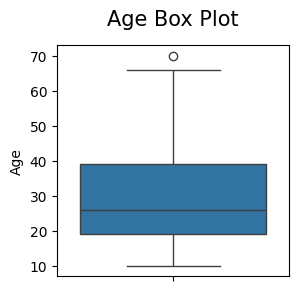

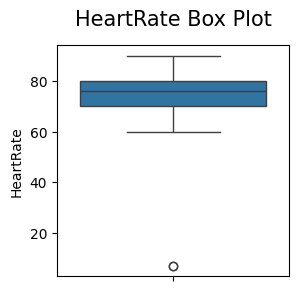

In [9]:
for var in df.filter(["Age", "HeartRate"]):
    plt.figure(figsize=(3, 3))
    sns.boxplot(data=df[var])
    plt.title(f"{var} Box Plot", fontsize=15, y=1.05)
    plt.show()

Compute the range limits where outliers start for the age and heartrate columns.

In [10]:
IQR_age = df["Age"].quantile(q=0.75) - df["Age"].quantile(q=0.25)
outlier_age = df["Age"].quantile(q=0.75) + 1.5 * IQR_age

IQR_hr = df["HeartRate"].quantile(q=0.75) - df["HeartRate"].quantile(q=0.25)
outlier_hr = df["HeartRate"].quantile(q=0.25) - 1.5 * IQR_hr

print(
    f"The upper limit for age is: {outlier_age}, "
    f"the lower limit for heartrate is: {outlier_hr}"
    )

The upper limit for age is: 69.0, the lower limit for heartrate is: 55.0


In [11]:
df.query(f"Age >= {outlier_age} | HeartRate < {outlier_hr}")

,Age,SystolicBP,DiastolicBP,BloodSugar,BodyTemp,HeartRate,RiskLevel
338,70,85,60,6.9,38.9,70,0
499,16,120,75,7.9,36.7,7,0
908,16,120,75,7.9,36.7,7,0


In [12]:
indices_to_drop = df.query(
                        f"Age >= {outlier_age} | HeartRate < {outlier_hr}"
                        ).index.to_list()
df.shape

(1014, 7)

In [13]:
df.drop(indices_to_drop).shape

(1011, 7)

**Imortant!** Now drop the three rows in the dataframe:

In [14]:
df_clean = df.drop(indices_to_drop)

In [15]:
df_clean.shape

(1011, 7)

---

# Correlation and PPS Analysis

Now that the data is cleaned (even though not much cleaning was necessary), we conduct a more detailed correlation study and in particular investigate the dataset for collinearity. This means, we look for features that are correlated between themselves and would thus decrease model performance. They contain similar information about the target and could lead to overfitting of the model. We also investigate the predictive power score to see which variables have the most predictive power over the target or between themselves. This study will help us to decide whether we include a Smart Correlation Selection in the feature engineering pipeline.

Note that in the correlation study in the MaternalHealthRiskStudy notebooks we did not consider Pearson correlation, since it is only useful for continuous variables and our target is categorical. Here however, we consider both Spearman and Pearson correlation, since we also investigate the correlation between the features and those are continuous.

In [16]:
# The code for this function was taken from the Code Institute
# Churnometer Walkthrough project and was adapted for the case at hand

def heatmap_corr(df, threshold, figsize=(20, 12), font_annot=8):
    """
    Generate a heatmap plot of correlation levels
    Hide the upper triangle due to symmetric plot
    Hide correlation levels below a set threshold
    """
    if len(df.columns) > 1:

        # hide upper triangle and levels below threshold
        mask = np.zeros_like(df, dtype=bool)
        mask[np.triu_indices_from(mask)] = True
        mask[abs(df) < threshold] = True

        # create heatmap figure
        fig, axes = plt.subplots(figsize=figsize)
        axes = sns.heatmap(
                df,
                annot=True,
                xticklabels=True,
                yticklabels=True,
                mask=mask,
                cmap='crest',
                annot_kws={"size": font_annot},
                ax=axes,
                linewidth=0.7
                )
        axes.set_title(
            f"Correlation Heatmap with Threshold {threshold}",
            fontsize=15,
            y=1.05
            )
        axes.set_yticklabels(df.columns, rotation=0)
        plt.ylim(len(df.columns), 0)
        plt.show()

    # add a return to save the figure
    return fig


def heatmap_pps(df, threshold, figsize=(20, 12), font_annot=8):
    """
    Generate a heatmap plot of predictive power scores
    Hide pps below a set threshold
    """
    if len(df.columns) > 1:

        # hide scores below threshold
        mask = np.zeros_like(df, dtype=bool)
        mask[abs(df) < threshold] = True

        # create heatmap figure
        fig, axes = plt.subplots(figsize=figsize)
        axes = sns.heatmap(
                    df,
                    annot=True,
                    xticklabels=True,
                    yticklabels=True,
                    mask=mask,
                    cmap='crest',
                    annot_kws={"size": font_annot},
                    linewidth=0.7)
        axes.set_title(
            f"PPS Heatmap with Threshold {threshold}",
            fontsize=15,
            y=1.05
            )
        plt.ylim(len(df.columns), 0)
        plt.show()

    # return figure to save it later
    return fig


def CalculateCorrAndPPS(df):
    """
    Computes Spearman and Pearson correlation levels
    Computes the pps matrix and pps statistics
    Print pps stats
    """
    # Calculate correlations for the datafram
    df_corr_spearman = df.corr(method="spearman", numeric_only=True)
    df_corr_pearson = df.corr(method="pearson", numeric_only=True)

    # Compute pps matrix and pivot
    pps_matrix_raw = pps.matrix(df)
    pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(index='y', columns='x', values='ppscore')  # noqa
    # Get pps stats and print
    pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T  # noqa
    print(
        "PPS threshold: Check the PPS score IQR to decide the threshold "
        "for the PPS heatmap \n"
        )
    print(pps_score_stats.round(3))

    return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(
        df_corr_pearson,
        df_corr_spearman,
        pps_matrix,
        CorrThreshold,
        PPS_Threshold,
        figsize=(20, 12),
        font_annot=8
        ):
    """
    Display the generated heatmaps and print a short summary
    """
    print("\n")
    print(
        "* Analyse how the target variable for your ML models are correlated "
        "with the other variables (features and target)"
        )
    print(
        "* Analyse multi-collinearity, that is, how the features are "
        "correlated among themselves"
        )

    print("\n")
    print("*** Heatmap: Spearman Correlation ***")
    print(
        "It evaluates the monotonic relationship and is useful also for "
        "correlation with the target \n"
        )
    heatmap_corr(
        df=df_corr_spearman,
        threshold=CorrThreshold,
        figsize=figsize,
        font_annot=font_annot
        )

    print("\n")
    print("*** Heatmap: Pearson Correlation ***")
    print(
        "It evaluates the linear relationship between two continuous "
        "variables (hence, only useful for the features amongst themselves) \n"
        )
    heatmap_corr(
        df=df_corr_pearson,
        threshold=CorrThreshold,
        figsize=figsize,
        font_annot=font_annot
        )

    print("\n")
    print("*** Heatmap: Predictive Power Score (PPS) ***")
    print(
        "PPS detects linear or non-linear relationships between two columns.\n"
        "The score ranges from 0 (no predictive power) to 1 "
        "(perfect predictive power) \n"
        )
    heatmap_pps(
        df=pps_matrix,
        threshold=PPS_Threshold,
        figsize=figsize,
        font_annot=font_annot
        )


In [17]:
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df_clean)

PPS threshold: Check the PPS score IQR to decide the threshold for the PPS heatmap 

         count   mean    std  min  25%    50%    75%    max
ppscore   42.0  0.096  0.121  0.0  0.0  0.062  0.132  0.522


From the pps matrix stats we can deduce which threshold to use for the heatmap: we choose a threshold of 0.15 for the PPS heatmap. For the correlatino we choose a threshold of 0.4 which corresponds to moderate correlation.



* Analyse how the target variable for your ML models are correlated with the other variables (features and target)
* Analyse multi-collinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates the monotonic relationship and is useful also for correlation with the target 



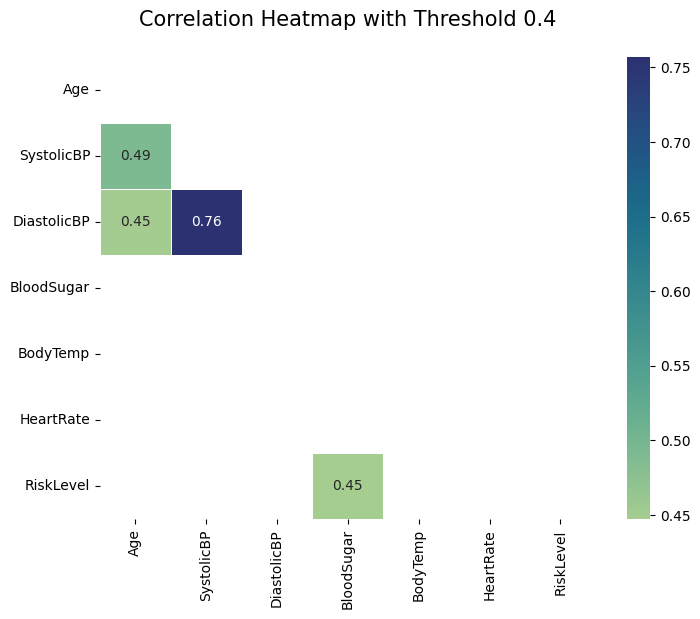



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables (hence, only useful for the features amongst themselves) 



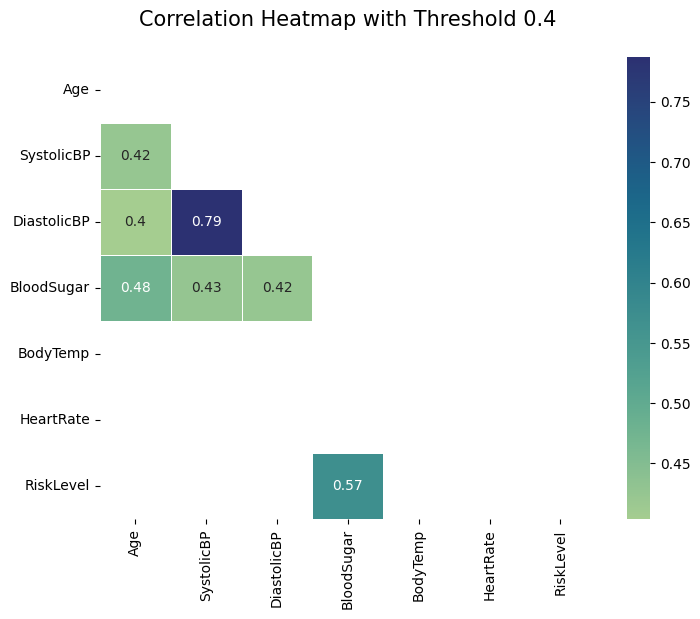



*** Heatmap: Predictive Power Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



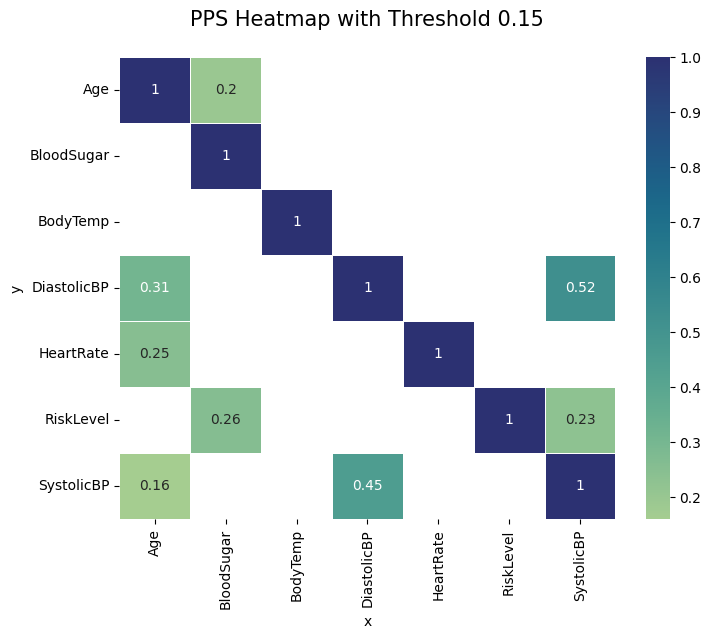

In [18]:
DisplayCorrAndPPS(
                df_corr_pearson=df_corr_pearson,
                df_corr_spearman=df_corr_spearman,
                pps_matrix=pps_matrix,
                CorrThreshold=0.4,
                PPS_Threshold=0.15,
                figsize=(8, 6),
                font_annot=10
                )

Store Spearman correlation and PPS heatmaps in variables

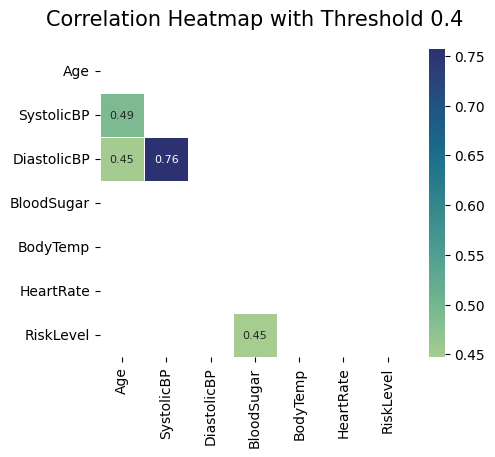

In [19]:
fig_corr_heatmap = heatmap_corr(
                        df_corr_spearman,
                        threshold=0.4,
                        figsize=(5, 4)
                        )

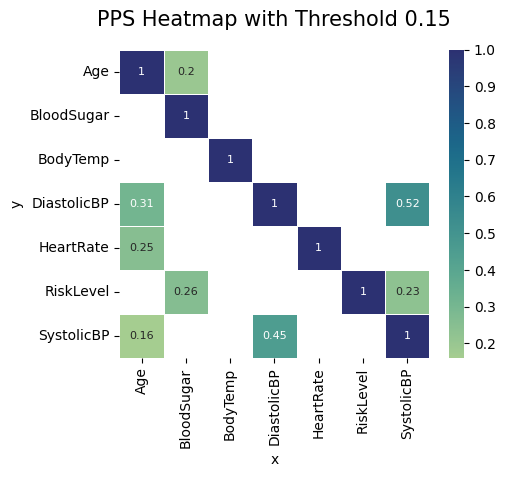

In [20]:
fig_pps_heatmap = heatmap_pps(pps_matrix, threshold=0.15, figsize=(5, 4))

### Correlation and PPS Analysis Summary

* Correlation Analysis:
  * We notice from the correlation heatmaps that the strongest correlation is between systolic and diasystolic blood pressure, which would be expected. Due to the collinearity, most likely one of the features will be dropped in the Smart Correlation Selection step in the feature engineering pipeline.
  * Age is also moderately correlated with the two types of blood pressure and in the Pearson correlation study, age and blood pressures are correlated with blood sugar.
  * Correlation with target: only the blood sugar shows a correlation level of more than 0.4 with the RiskLevel.
* PPS Analysis:
  * The strongest predictive power over the target is seen with blood sugar and systolic BP.
  * Systolic BP has strong predictive power over diastolic BP and slightly less the other way around.
  * Age has some predictive power over several health markers (i.e. blood pressure and heart rate) and blood sugar has some predictive power over age (as well as the target, see above).
* Conclusion: 
  * These observations are in accordance with the first observations made in the MaternalHealthRiskStudyA notebook.
  * It will certainly be interesting to include a Smart Correlation Selector step in the feature engineering pipeline, since this could improve model performance due to avoiding collinearity.

---

## Split into Train and Test Sets

Split the cleaned dataset into train and test set, where the test set is 20% of the whole dataset.

Note that the pipeline steps we will include in our ML pipeline, will automatically split the train set into train and validation set.

The two sets will the be saved to outputs.

In [21]:

train_set, test_set, _, __ = train_test_split(
                                        df_clean,
                                        df_clean['RiskLevel'],
                                        test_size=0.2,
                                        random_state=0)

print(f"Train set shape: {train_set.shape} \nTest set shape: {test_set.shape}")

Train set shape: (808, 7) 
Test set shape: (203, 7)


---

## Push Files to Repo

In [22]:

try:
    # create outputs/datasets/cleaned folder
    os.makedirs(name='outputs/datasets/cleaned')
except Exception as e:
    print(e)

try:
    # create outputs/plots folder
    os.makedirs(name='outputs/plots/cleaned')
except Exception as e:
    print(e)

try:
    # create documentation/plots folder
    os.makedirs(name='documentation/plots')
except Exception as e:
    print(e)

[Errno 17] File exists: 'outputs/datasets/cleaned'
[Errno 17] File exists: 'outputs/plots/cleaned'
[Errno 17] File exists: 'documentation/plots'


### Cleaned Data

Full dataset with erronous data removed:

In [23]:
df_clean.to_csv(
    "outputs/datasets/cleaned/maternal-health-risk-dataset-clean.csv",
    index=False
    )

### Train Set

In [24]:
train_set.to_csv("outputs/datasets/cleaned/train-set-clean.csv", index=False)

### Test Set

In [25]:
test_set.to_csv("outputs/datasets/cleaned/test-set-clean.csv", index=False)

### Heatmap Plots

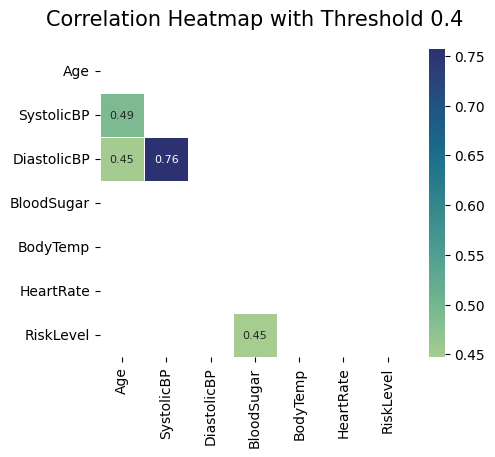

In [26]:
fig_corr_heatmap

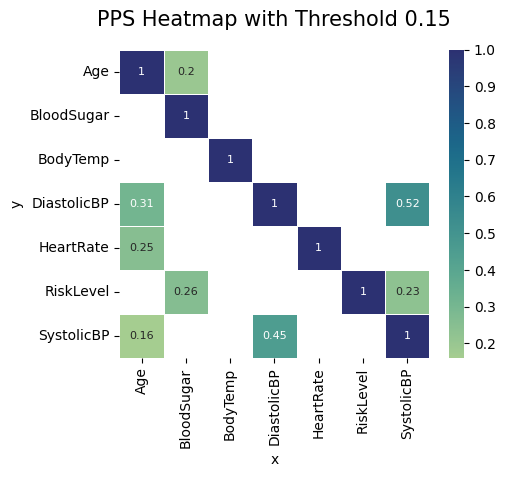

In [27]:
fig_pps_heatmap

Save to outputs

In [28]:
fig_corr_heatmap.savefig(
    "outputs/plots/correlation_spearman_heatmap.png",
    bbox_inches='tight'
    )
fig_pps_heatmap.savefig(
    "outputs/plots/pps_heatmap.png",
    bbox_inches='tight'
    )

Save to documentation

In [29]:
fig_corr_heatmap.savefig(
    "documentation/plots/correlation_spearman_heatmap.png",
    bbox_inches='tight'
    )
fig_pps_heatmap.savefig(
    "documentation/plots/pps_heatmap.png",
    bbox_inches='tight'
    )

---

# Conclusions and Next Steps



* We removed a few outliers that seemed to be erronous entries into the database, we stored the clean dataset to outputs/datasets/cleaned
* We conducted a correlation and PPS analysis and decided to include a Smart Correlation step into our feature engineering pipeline
* We then split the cleaned dataset into train and test sets and stored them to outputs/datasets/cleaned
* In the next notebook we will study the data further and decide which other steps to include in the feature engineering pipeline